In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import glob
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision

from torch.utils.tensorboard import SummaryWriter

import sklearn
import functools
import operator

import sys

sys.path.insert(1,"/home/sbulusu/qcd_ml/neural_networks/libs/")

import dataset_class_gsimage
import aenc_torch_net_class
import aenc_utils
import utils

In [8]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Utilizing CUDA")
else:
    device = torch.device("cpu")
    print("Utilizing CPU")

Utilizing CUDA


In [9]:
#mnist_image_folder = "mnist/"
mnist_image_folder = "../data/mnist/"
mnist_image_names = os.listdir(mnist_image_folder)
mnist_image_paths = glob.glob("mnist/*")
#mnist_image_paths = []
#for mnist_image_name in mnist_image_names:
#    mnist_image_paths.append(mnist_image_folder + "/" + mnist_image_name)
#print(mnist_image_paths)
image_size = [1,28,28]
label_path_csv = "../data/mnist_labels.csv"
dataset = dataset_class_gsimage.image_dataset(mnist_image_folder, mnist_image_paths, image_size, label_path_csv)
target_attributes = ["number"]
dataset.set_label_names(target_attributes)
#output_attributes = [str(i) for i in range(0,10)]
#pred_attributes = [str(i) for i in range(np.prod(image_size))]

['number']

[5.]


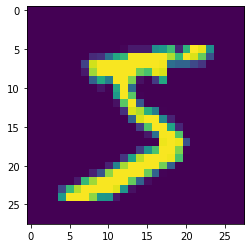

In [10]:
i = 0
plt.imshow(dataset.get_image(i)[0].reshape([28,28]))
print(dataset.get_image(i)[1])

In [11]:
"""
HYPERPARAMETERS
"""

random_seed = 42
np.random.seed(random_seed)
torch.manual_seed(random_seed)

val_epochs = [10,20,30,40,50,60,70]
#val_epochs = [1,2]
save_state_epochs = [10000]


"""Manually set network structure"""
"""
    This list can be loaded into the constructor of the Net neural network class, to automatically generate the network structure
    type = pointer to the layer function'
    layer_pars = parameters which must be given to the layer function in order to initialize it
    act_func = activation function to be applied directly after feeding to the corresponding layer
    dropout = certain neurons cna be dropped out if specified
"""

#fixed_net_struct = []
input_size = dataset.get_input_size()
#target_size = len(target_attributes)
#output_size = target_size
#output_size = len(output_attributes)
output_size = input_size

"""
#[ [[in_channels, out_channels],[kernel_size], stride, padding], ... ]
#kernel_pars = [ [[input_size[0],4],[12,3],1,0], [[4,8],[12,3],1,0], [[8,16],[12,3],1,0], [[16,16],[12,3],1,0], [[16,16],[8,2],1,0] ]
kernel_pars = [ [[input_size[0],4],[9,3],1,0], [[4,4],[4,1],[4,1],0], [[4,8],[13,3],1,0], [[8,8],[4,1],[4,1],0], [[8,16],[4,3],1,0]]
act_func = torch.relu
#, "act_func": act_func
for i, kernel_par in enumerate(kernel_pars):
    if i%2 == 0:
        layer_type = nn.Conv2d
        fixed_net_struct.append( {"type": layer_type, "layer_pars": {"in_channels": kernel_par[0][0], "out_channels": kernel_par[0][1], "kernel_size": kernel_par[1], "stride": kernel_par[2], "padding": kernel_par[3], "bias": True}} )
    else:
        #layer_type = nn.MaxPool2d
        layer_type = nn.AvgPool2d
        fixed_net_struct.append( {"type": layer_type, "layer_pars": {"kernel_size": kernel_par[1], "stride": kernel_par[2], "padding": kernel_par[3]}} )
"""
"""
for i, kernel_par in enumerate(kernel_pars):
        layer_type = nn.Conv2d
        fixed_net_struct.append( {"type": layer_type, "layer_pars": {"in_channels": kernel_par[0][0], "out_channels": kernel_par[0][1], "kernel_size": kernel_par[1], "stride": kernel_par[2], "padding": kernel_par[3], "bias": True}, "act_func": act_func} )
    
"""
"""
conv_sizes = utils.calc_layer_sizes(input_size, fixed_net_struct)
fc_input_size = np.product(conv_sizes[-1])
"""

encoder_struct = []
decoder_struct = []
latent_size = 10

act_func = torch.relu

fc_input_size = np.product(input_size)
print(fc_input_size)
encoder_struct.append( {"type": nn.Flatten, "layer_pars": {"start_dim": 1}} )
encoder_struct.append( {"type": nn.Linear, "layer_pars": {"in_features": fc_input_size, "out_features": fc_input_size//4}, "bias": True, "act_func": act_func} )
encoder_struct.append( {"type": nn.Linear, "layer_pars": {"in_features": fc_input_size//4, "out_features": fc_input_size//16}, "bias": True, "act_func": act_func} )
encoder_struct.append( {"type": nn.Linear, "layer_pars": {"in_features": fc_input_size//16, "out_features": latent_size}, "bias": True, "act_func": act_func} )

decoder_struct.append( {"type": nn.Linear, "layer_pars": {"in_features": latent_size, "out_features": fc_input_size//16}, "bias": True, "act_func": act_func} )
decoder_struct.append( {"type": nn.Linear, "layer_pars": {"in_features": fc_input_size//16, "out_features": fc_input_size//4}, "bias": True, "act_func": act_func} )
decoder_struct.append( {"type": nn.Linear, "layer_pars": {"in_features": fc_input_size//4, "out_features": fc_input_size}, "bias": True, "act_func": act_func} )
decoder_struct.append( {"type": utils.Reshape, "layer_pars": {"new_shape": np.concatenate(([-1],input_size))}} )
#fixed_net_struct.append( {"type": nn.Softmax, "layer_pars": {"dim": 1}} )
#dim 0 or 1???
#fixed_net_struct.append( {"type": nn.ConvTranspose2d, "layer_pars": {"in_channels": 1, "out_channels": 1, "kernel_size": [1,1], "stride": 1, "padding": 1, "bias": True}, "act_func": act_func} )

#layer_sizes = utils.calc_layer_sizes(input_size, fixed_net_struct)
#print(layer_sizes)

"""create list of parameters manually"""

hyper_parameters = {}
#hyper_parameters["loss_func"] = nn.CrossEntropyLoss
hyper_parameters["loss_func"] = nn.MSELoss
hyper_parameters["optimizer"] = optim.Adam
hyper_parameters["batch_size"] = 1 
hyper_parameters["lr"] = 0.0001
#hyper_parameters["net_struct"] = fixed_net_struct

hyper_parameters["val_method"] = "holdout"
hyper_parameters["val_method_pars"] = {"train" : 0.9, "val" : 0.1, "test" : 0.}
#hyper_parameters["val_method"] = "k_fold"
#hyper_parameters["val_method_pars"] = 5

784


In [12]:
epochs = max(val_epochs)+1

lr=hyper_parameters["lr"]
batch_size = hyper_parameters["batch_size"]
loss_func = hyper_parameters["loss_func"]()
#net_struct = hyper_parameters["net_struct"]
val_method = hyper_parameters["val_method"]
val_method_pars = hyper_parameters["val_method_pars"]
optimizer_type = hyper_parameters["optimizer"]

val_pred_paths = []
val_label_paths = []

train_loss = np.zeros(epochs)
val_loss = np.zeros(len(val_epochs))

net_state_paths = []

#create training log
log_file_name = "log.txt"
log_file = open(log_file_name, "w")

In [13]:
#tb = SummaryWriter()

#net = torch_net_class.Net(net_struct, dataset.get_input_size())    
net = aenc_torch_net_class.AutoEncoder(encoder_struct=encoder_struct, decoder_struct=decoder_struct, input_size=input_size, latent_size=latent_size)
#net.init_weights(torch.nn.init.xavier_normal_)
net.set_batch_size(batch_size)
#net.set_layer_sizes(layer_sizes)
net.to(device)
#net.show_layers()
net_parameters = net.parameters()

optimizer = optimizer_type(net_parameters, lr=lr)

Initializing Encoder:

Adding {'type': <class 'torch.nn.modules.flatten.Flatten'>, 'layer_pars': {'start_dim': 1}}

Adding {'type': <class 'torch.nn.modules.linear.Linear'>, 'layer_pars': {'in_features': 784, 'out_features': 196}, 'bias': True, 'act_func': <built-in method relu of type object at 0x7f7e5cb93be0>}

Adding {'type': <class 'torch.nn.modules.linear.Linear'>, 'layer_pars': {'in_features': 196, 'out_features': 49}, 'bias': True, 'act_func': <built-in method relu of type object at 0x7f7e5cb93be0>}

Adding {'type': <class 'torch.nn.modules.linear.Linear'>, 'layer_pars': {'in_features': 49, 'out_features': 10}, 'bias': True, 'act_func': <built-in method relu of type object at 0x7f7e5cb93be0>}

Initializing weights of Encoder with method <function xavier_normal_ at 0x7f7e0e09b830>

Initializing Decoder:

Adding {'type': <class 'torch.nn.modules.linear.Linear'>, 'layer_pars': {'in_features': 10, 'out_features': 49}, 'bias': True, 'act_func': <built-in method relu of type object at

In [ ]:
"""SPECIFY OUTSIDE FOR K-FOLD VALIDATION"""
data_loader = utils.load_split_data(dataset=dataset, batch_size=batch_size, method=val_method, method_pars=val_method_pars, random_seed=random_seed, log_file=log_file)

if val_method == "holdout":
    data_loader = data_loader[0]
    test_loader = data_loader[2]
val_loader = data_loader[1]
train_loader = data_loader[0]

val_dir = "val/"
try:
    os.makedirs(val_dir)
except FileExistsError:
    pass
train_state_dir = "net_states/"
try:
    os.makedirs(train_state_dir)
except FileExistsError:
    pass

epoch = 0
val_i = 0
for epoch in range(epochs):
    
    batch_nr = 0
    epoch_loss = np.zeros(len(train_loader))
    
    """Actual training step"""
    for train_mini_batch in train_loader:
        batch_loss, train_output = utils.step(net, train_mini_batch, output_size, loss_func, optimizer, device, mode="train", log_file=log_file)
        epoch_loss[batch_nr] = batch_loss.item()
        batch_nr += 1
    mean_epoch_loss = epoch_loss.mean()
    train_loss[epoch] = mean_epoch_loss
    print(f"mean epoch {epoch} train loss: {mean_epoch_loss}\n")
    
    
    """save the neural networks state"""
    if epoch in save_state_epochs:
        train_state_epoch_file_path = train_state_dir + f"state_epoch_{epoch}"
        train_state = {"epoch" : epoch, "state_dict": net.state_dict(), "optimizer": optimizer.state_dict()}
        torch.save(train_state, train_state_epoch_file_path)
        net_state_paths.append(train_state_epoch_file_path)
        print(f"saved model from epoch {epoch}")
        
    """
    Validation
    """
    #val_epochs = [100000]
    if epoch in val_epochs:
        val_label = []
        val_pred = []
        
        val_batch_nr = 0
        val_epoch_loss = np.zeros(len(val_loader))
        
        for val_mini_batch in val_loader:
            label_batch = val_mini_batch[1]
            val_label.append(label_batch.detach().cpu().numpy())
            val_batch_loss, val_output = utils.step(net, val_mini_batch, output_size, loss_func, optimizer, device, mode="val", log_file=log_file)
            val_epoch_loss[val_batch_nr] = val_batch_loss.item()
            val_pred.append(val_output.detach().cpu().numpy())
            """
            class_batch_pred = []
            #print(val_output)
            for val in val_output:
                class_index = val.argmax().detach().cpu()
                class_batch_pred.append(class_index)
            #print(class_batch_pred)
            val_pred.append(class_batch_pred)
            """
            val_batch_nr += 1
            
        mean_val_epoch_loss = val_epoch_loss.mean()
        val_loss[val_i] = mean_val_epoch_loss
        print(f"mean epoch {epoch} val loss: {mean_val_epoch_loss}\n")
        
        val_i += 1
        
        val_pred_path = val_dir + "/" + f"val_epoch_{epoch}_pred"
        val_label_path = val_dir + "/" + f"val_epoch_{epoch}_labels"
        #print(np.array(functools.reduce(operator.iconcat, val_pred, [])))
        np.array(functools.reduce(operator.iconcat, val_pred, [])).tofile(val_pred_path, sep=" ")
        np.array(functools.reduce(operator.iconcat, val_label, [])).tofile(val_label_path, sep=" ")
        #np.array(val_pred).tofile(val_pred_path)
        #np.array(val_label).tofile(val_pred_label)
        
        val_pred_paths.append(val_pred_path)
        val_label_paths.append(val_label_path)
        
log_file.close()

size of val set :1112

size of train set :8888

mean epoch 0 train loss: 3913.1615048399067

mean epoch 1 train loss: 3064.008466784102

mean epoch 2 train loss: 2793.3536930341747

mean epoch 3 train loss: 2631.5645873879225

mean epoch 4 train loss: 2535.7230297572755

mean epoch 5 train loss: 2460.963669472187

mean epoch 6 train loss: 2406.336803968483

mean epoch 7 train loss: 2365.0586627441735

mean epoch 8 train loss: 2302.9969598150383

mean epoch 9 train loss: 2266.710144441263

mean epoch 10 train loss: 2235.0770138775733

mean epoch 10 val loss: 2238.6495536557204

mean epoch 11 train loss: 2213.3945254112127

mean epoch 12 train loss: 2178.580081510501

mean epoch 13 train loss: 2123.2054137136356

mean epoch 14 train loss: 2104.7678710635346

mean epoch 15 train loss: 2088.5699578979657

mean epoch 16 train loss: 2074.459463668878

mean epoch 17 train loss: 2058.7973866964867

mean epoch 18 train loss: 2025.2399283682946

mean epoch 19 train loss: 1998.6495706917035

mean

In [ ]:
"""train_state_file_path = train_state_dir + f"state_epoch_{epoch}"
#train_state = {"epoch" : epoch, "state_dict": net.state_dict(), "optimizer": optimizer.state_dict()}
torch.save(net.state_dict(), train_state_file_path)
net_state_paths.append(train_state_epoch_file_path)
print(f"saved model from epoch {epoch}")"""

In [14]:

net_state_path = "net_states/state_epoch_30"
net.load_state_dict(torch.load(net_state_path))
#net.eval()


<All keys matched successfully>

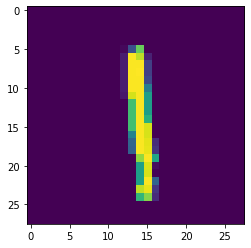

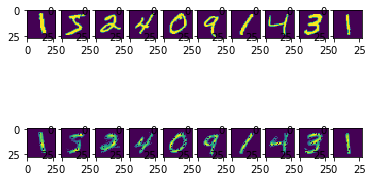

In [15]:
test_image, test_label = dataset[0]
indices = np.arange(0,10)
test_sampler = torch.utils.data.sampler.SubsetRandomSampler(indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=1, sampler=test_sampler)
test_images = []
outputs = []
for test_batch in train_loader:
    test_image = test_batch[0].to(device)
    test_images.append(test_image)
    plt.imshow(test_image.cpu()[0,0])
    net.eval()
    output = net.forward(test_image.float())
    outputs.append(output)

num_images = len(outputs)
fig, ax = plt.subplots(2,num_images)
for image_i in range(num_images):
    ax[0, image_i].imshow(test_images[image_i].cpu()[0,0])
    ax[1, image_i].imshow(outputs[image_i].detach().cpu()[0,0])

In [17]:
num_samples = 10
latent_samples = torch.randint(low=1, high=1000, size=(num_samples, latent_size) )

"""latent_samples_indices = np.random.randint(low=0, high=9, size=num_samples)
latent_samples = np.zeros((num_samples, latent_size))
latent_samples[np.arange(num_samples),latent_samples_indices] +=1
latent_samples = torch.tensor(latent_samples)
print(latent_samples[0])"""

'latent_samples_indices = np.random.randint(low=0, high=9, size=num_samples)\nlatent_samples = np.zeros((num_samples, latent_size))\nlatent_samples[np.arange(num_samples),latent_samples_indices] +=1\nlatent_samples = torch.tensor(latent_samples)\nprint(latent_samples[0])'

torch.Size([10, 1, 28, 28])
10


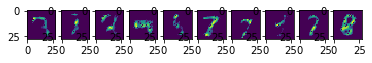

In [18]:
output = net.decoder(latent_samples.to(device).float())
print(output.size())
print(len(output))
fig, ax = plt.subplots(1,num_samples)
for i in range(num_samples):
    ax[i].imshow(output.detach().cpu()[i][0])
    